In [157]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from sklearn.metrics import r2_score
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [158]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,BatchIndex,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
0,0,-0.260848,0.123912,0.937022,25.2,108.666275
1,1,-0.344876,0.116629,1.033851,26.9,109.853065
2,2,-0.339656,0.115659,1.027957,27.9,112.921150
3,3,-0.317045,0.126365,0.993998,28.6,112.257874
4,4,-0.284570,0.122794,0.971008,25.3,112.399788


<Axes: >

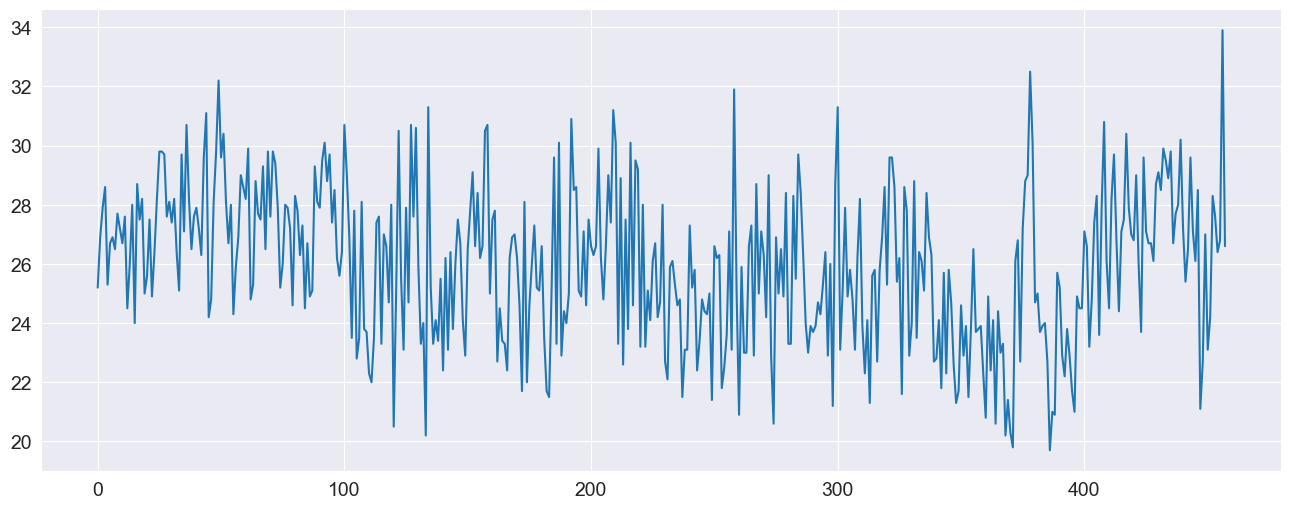

In [159]:
data15.CUM_Steam.plot()

## QQ Plot

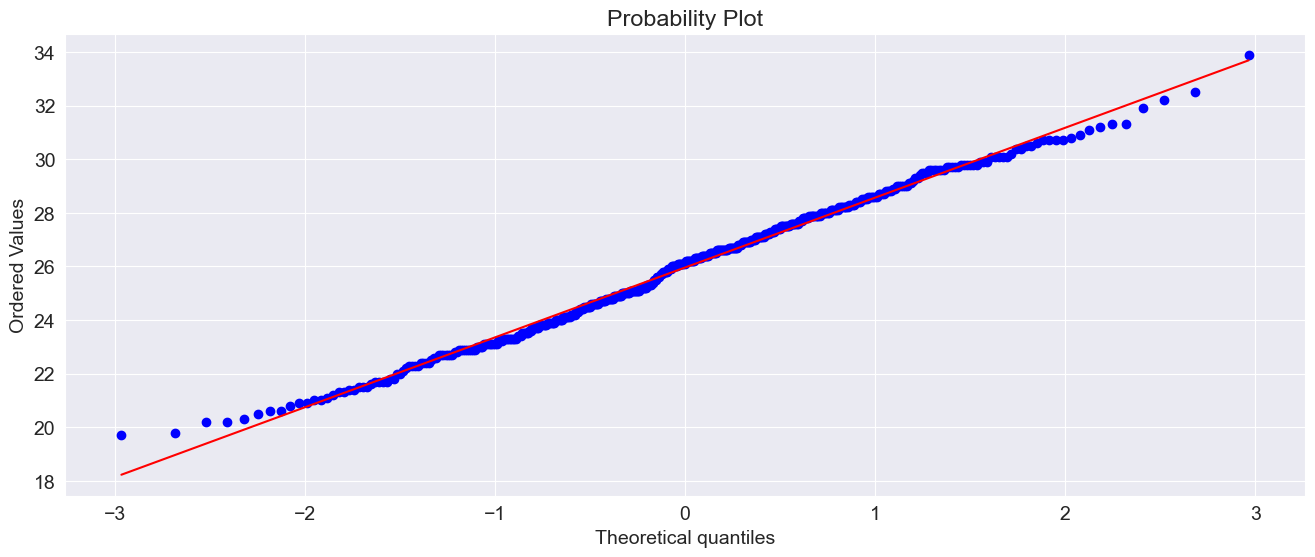

In [160]:
scipy.stats.probplot(data15.CUM_Steam, plot=pylab)
pylab.show()

In [161]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['BatchIndex'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [162]:
data15.head()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 00:00:00,-0.260848,0.123912,0.937022,25.2,108.666275
2023-01-01 00:01:00,-0.344876,0.116629,1.033851,26.9,109.853065
2023-01-01 00:02:00,-0.339656,0.115659,1.027957,27.9,112.921150
2023-01-01 00:03:00,-0.317045,0.126365,0.993998,28.6,112.257874
2023-01-01 00:04:00,-0.284570,0.122794,0.971008,25.3,112.399788


In [163]:
data15_train = data15[:412]
data15_test = data15[412:]

In [164]:
data15_train.tail()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 06:47:00,-0.214339,0.007323,1.014626,27.9,95.201584
2023-01-01 06:48:00,-0.583381,0.136749,1.215810,30.8,95.179120
2023-01-01 06:49:00,-0.359145,0.132851,1.018535,26.1,95.548090
2023-01-01 06:50:00,-0.212672,0.132671,0.838498,24.5,95.176450
2023-01-01 06:51:00,-0.275103,0.022933,0.896457,28.2,95.168365


In [165]:
data15_test.head

<bound method NDFrame.head of                         Delta  Damkohler     Sigma  CUM_Steam  Woodloading
Time                                                                      
2023-01-01 06:52:00 -0.279108   0.129834  0.987864       29.7    95.179190
2023-01-01 06:53:00 -0.288021   0.138864  0.954996       26.8    93.540530
2023-01-01 06:54:00 -0.284720   0.145218  0.938413       24.4    96.737830
2023-01-01 06:55:00 -0.286299   0.129122  0.941070       27.1    97.097946
2023-01-01 06:56:00 -0.298729   0.129506  0.977630       27.5   119.443611
2023-01-01 06:57:00 -0.301572   0.119907  0.982622       30.4   119.783524
2023-01-01 06:58:00 -0.298558   0.143207  0.983130       27.9   113.750542
2023-01-01 06:59:00 -0.290024   0.131177  0.953827       27.0   115.094070
2023-01-01 07:00:00 -0.298151   0.133075  0.973398       26.8   115.286476
2023-01-01 07:01:00 -0.307432   0.125940  1.001226       29.0   115.359390
2023-01-01 07:02:00 -0.285483   0.136893  0.947714       26.0   100.71

### Stationarity

In [166]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.589252897357407,
 0.00013519121068810783,
 6,
 451,
 {'1%': -3.444932949082776,
  '5%': -2.867969899953726,
  '10%': -2.57019489663276},
 2018.1619851085152)

### ACF

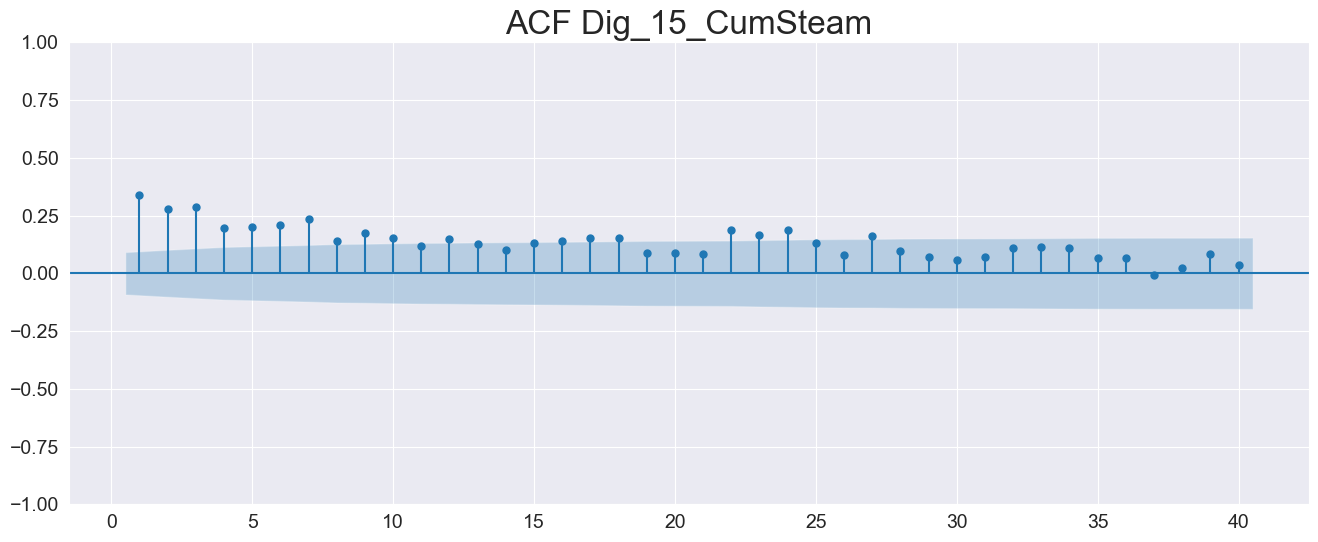

In [167]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("ACF Dig_15_CumSteam", size = 24)
plt.show()

### PACF

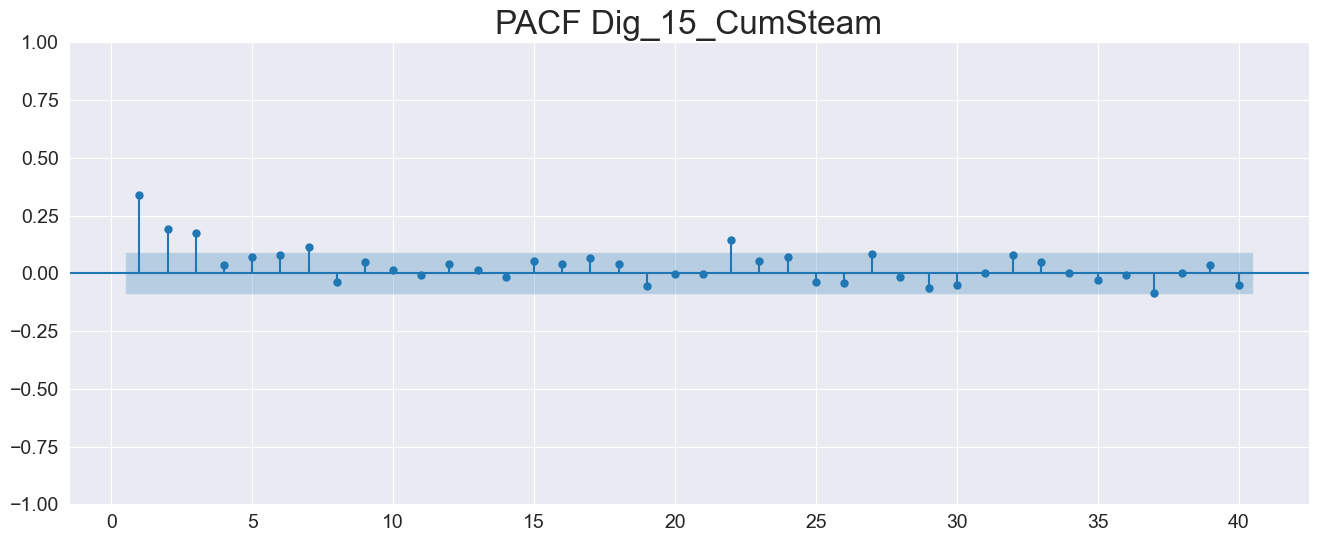

In [168]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_CumSteam", size = 24)
plt.show()

In [169]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p

### AR Models

In [170]:
#AR1
model_ar1 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 0))
results_ar1 = model_ar1.fit()
print(results_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -953.385
Date:                Mon, 18 Mar 2024   AIC                           1912.770
Time:                        20:45:58   BIC                           1924.833
Sample:                    01-01-2023   HQIC                          1917.542
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8082      0.180    143.129      0.000      25.455      26.162
ar.L1          0.3286      0.045      7.321      0.000       0.241       0.417
sigma2         5.9886      0.494     12.119      0.0

In [171]:
#AR2
model_ar2 = ARIMA(data15_train.CUM_Steam, order=(2, 0, 0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())
print("LLR test: " + str(LLR_test(model_ar1, model_ar2)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -945.142
Date:                Mon, 18 Mar 2024   AIC                           1898.285
Time:                        20:46:39   BIC                           1914.369
Sample:                    01-01-2023   HQIC                          1904.647
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8097      0.220    117.199      0.000      25.378      26.241
ar.L1          0.2630      0.046      5.664      0.000       0.172       0.354
ar.L2          0.1981      0.045      4.372      0.0

In [172]:
#AR3
model_ar3 = ARIMA(data15_train.CUM_Steam, order=(3, 0, 0))
results_ar3 = model_ar3.fit()
print(results_ar3.summary())
print("LLR test: " + str(LLR_test(model_ar2, model_ar3)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -940.555
Date:                Mon, 18 Mar 2024   AIC                           1891.110
Time:                        20:47:49   BIC                           1911.215
Sample:                    01-01-2023   HQIC                          1899.063
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8126      0.257    100.588      0.000      25.310      26.316
ar.L1          0.2334      0.048      4.862      0.000       0.139       0.327
ar.L2          0.1587      0.045      3.552      0.0

In [173]:
#AR4
model_ar4 = ARIMA(data15_train.CUM_Steam, order=(4, 0, 0))
results_ar4 = model_ar4.fit()
print(results_ar4.summary())
print("LLR test: " + str(LLR_test(model_ar3, model_ar4)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -940.493
Date:                Mon, 18 Mar 2024   AIC                           1892.987
Time:                        20:52:55   BIC                           1917.113
Sample:                    01-01-2023   HQIC                          1902.530
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8137      0.261     98.875      0.000      25.302      26.325
ar.L1          0.2309      0.048      4.774      0.000       0.136       0.326
ar.L2          0.1558      0.045      3.458      0.0

In [174]:
#ARMA
model_arma11 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 1))
results_arma = model_arma11.fit()
print(results_arma.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -937.841
Date:                Mon, 18 Mar 2024   AIC                           1883.682
Time:                        20:53:50   BIC                           1899.766
Sample:                    01-01-2023   HQIC                          1890.044
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8400      0.365     70.792      0.000      25.125      26.555
ar.L1          0.9124      0.036     25.288      0.000       0.842       0.983
ma.L1         -0.7264      0.054    -13.362      0.0

In [175]:
#ARMA12
model_arma12 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 2))
results_arma = model_arma12.fit()
print(results_arma.summary())
print("LLR test: " + str(LLR_test(model_arma11, model_arma12)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -937.485
Date:                Mon, 18 Mar 2024   AIC                           1884.970
Time:                        20:54:36   BIC                           1905.075
Sample:                    01-01-2023   HQIC                          1892.923
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8495      0.401     64.395      0.000      25.063      26.636
ar.L1          0.9353      0.032     29.523      0.000       0.873       0.997
ma.L1         -0.7278      0.055    -13.342      0.0

In [123]:
#************************** ARIMA 111 IS THE CORRECT MODEL ******************************#

#ARIMA111

model_arima111 = ARIMA(data15_train.CUM_Steam, order=(1, 1, 1))
results_arima111 = model_arima111.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arma11)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -846.484
Date:                Fri, 15 Mar 2024   AIC                           1698.967
Time:                        12:34:26   BIC                           1710.716
Sample:                    01-01-2023   HQIC                          1703.634
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      0.058      0.842      0.400      -0.065       0.162
ma.L1         -0.9202      0.024    -37.884      0.000      -0.968      -0.873
sigma2         5.5876      0.393     14.235      0.0

In [124]:
#ARIMA
model_arima121 = ARIMA(data15_train.CUM_Steam, order=(1, 2, 1))
results_arima121 = model_arima121.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arima121)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -846.484
Date:                Fri, 15 Mar 2024   AIC                           1698.967
Time:                        12:34:35   BIC                           1710.716
Sample:                    01-01-2023   HQIC                          1703.634
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      0.058      0.842      0.400      -0.065       0.162
ma.L1         -0.9202      0.024    -37.884      0.000      -0.968      -0.873
sigma2         5.5876      0.393     14.235      0.0

### ARIMA111 Training Plots

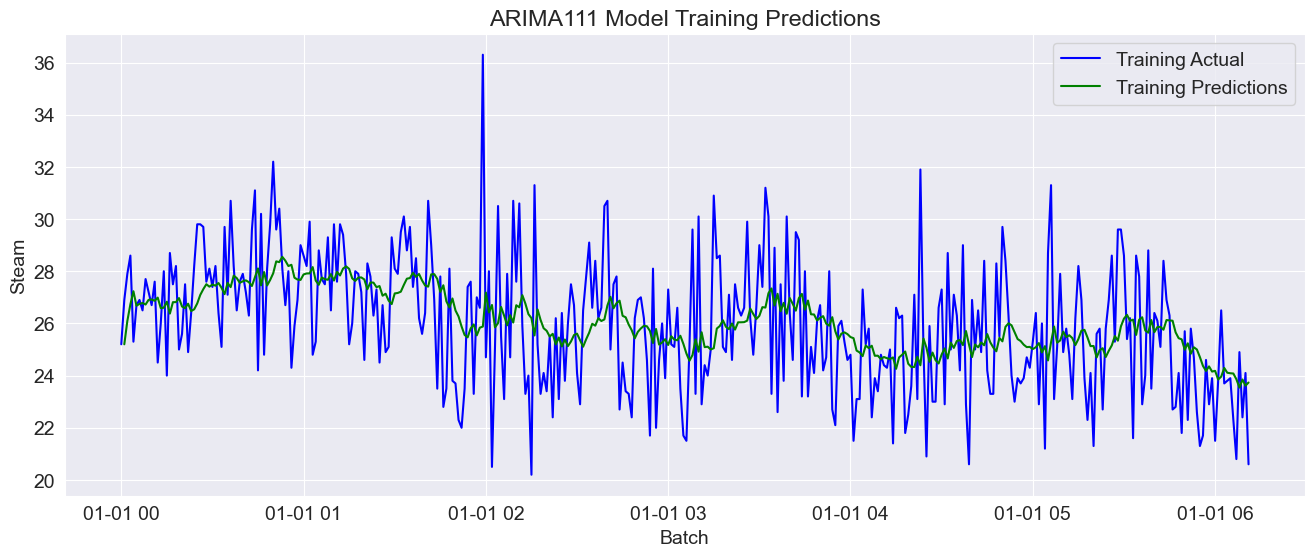

In [125]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima111.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima111.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA111 Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMA111 Training Performance

In [126]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.sqrt(mean_absolute_percentage_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

r_squared = r2_score(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('mae', mae)
print('rmse', rmse)
print('mape', mape)
print('r2', r_squared)

mae 1.9569423202429472
rmse 2.700013381547528
mape 0.2764945794762829
r2 -0.11980157234299216


### ARIMA111 Test Plots

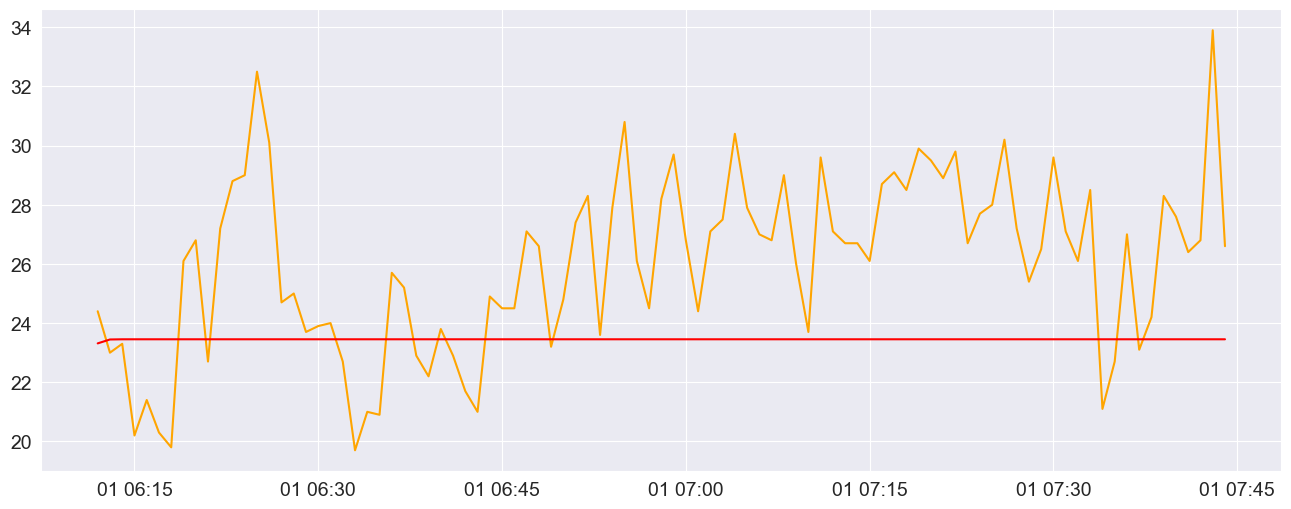

In [127]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMA111 Test Performance

In [128]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.sqrt(mean_absolute_percentage_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))

r_squared = r2_score(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

print('mae', mae)
print('rmse', rmse)
print('mape', mape)
print('r2', r_squared)

mae 3.2488101448482087
rmse 3.8915725941465342
mape 0.3457195031431028
r2 -0.7349411558151961


### ARIMAX With Woodload

In [129]:
# Define exogenous variables
exog_vars = data15_train[['Woodloading']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(1,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -845.463
Date:                Fri, 15 Mar 2024   AIC                           1698.926
Time:                        12:34:49   BIC                           1714.590
Sample:                    01-01-2023   HQIC                          1705.147
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Woodloading    -0.0237      0.017     -1.391      0.164      -0.057       0.010
ar.L1           0.0363      0.058      0.620      0.535      -0.078       0.151
ma.L1          -0.9172      0.025    -37.086      0.000      -0.966      -0.869
sigma2          5.5569      0.388     14.316      0.000       4.796       6.318
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.03
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.39
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX111 with Woodload Training Plots

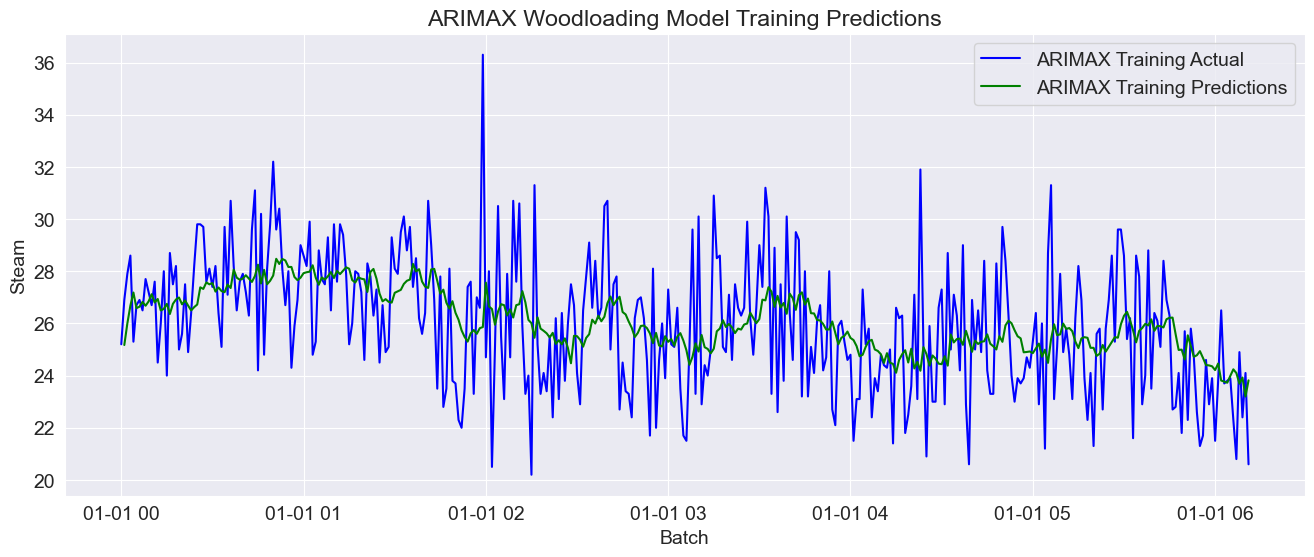

In [130]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'
exog_vars_test = data15_test[['Woodloading']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Woodloading Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMAX111 Woodload Training Performance

In [131]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.sqrt(mean_absolute_percentage_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

r_squared = r2_score(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('mae', mae)
print('rmse', rmse)
print('mape', mape)
print('r2', r_squared)

mae 1.9597868249575203
rmse 2.7616999867399494
mape 0.276710984498304
r2 -0.17155379595906317


### ARIMAX with Woodload test plots

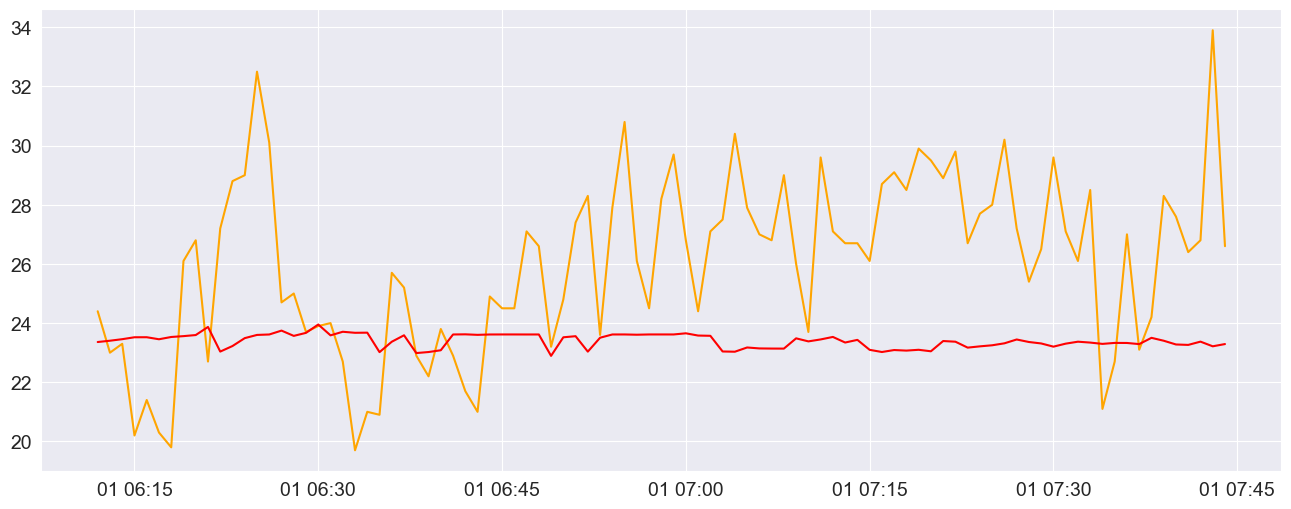

In [132]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMAX with Woodload test performance

In [133]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.sqrt(mean_absolute_percentage_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

r_squared = r2_score(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

print('mae', mae)
print('rmse', rmse)
print('mape', mape)
print('r2', r_squared)

mae 3.296320308605844
rmse 3.9764452535230235
mape 0.3480319787972575
r2 -0.8114422459153472


### ARIMAX with all Parameters

In [134]:
# Define exogenous variables
exog_vars = data15_train[['Delta', 'Damkohler', 'Sigma']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(1,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -704.275
Date:                Fri, 15 Mar 2024   AIC                           1420.549
Time:                        12:34:59   BIC                           1444.046
Sample:                    01-01-2023   HQIC                          1429.881
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Delta         -1.9717      1.146     -1.721      0.085      -4.217       0.274
Damkohler      7.1833      1.605      4.476      0.000       4.038      10.329
Sigma         14.7848      0.973     15.188      0.000      12.877      16.693
ar.L1          0.1398      0.057      2.443      0.015       0.028       0.252
ma.L1         -0.9636      0.014    -68.400      0.000      -0.991      -0.936
sigma2         2.5918      0.200     12.967      0.000       2.200       2.984
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.84   Prob(JB):                         0.94
Heteroskedasticity (H):               0.82   Skew:                             0.03
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX111 with all parameters training plots

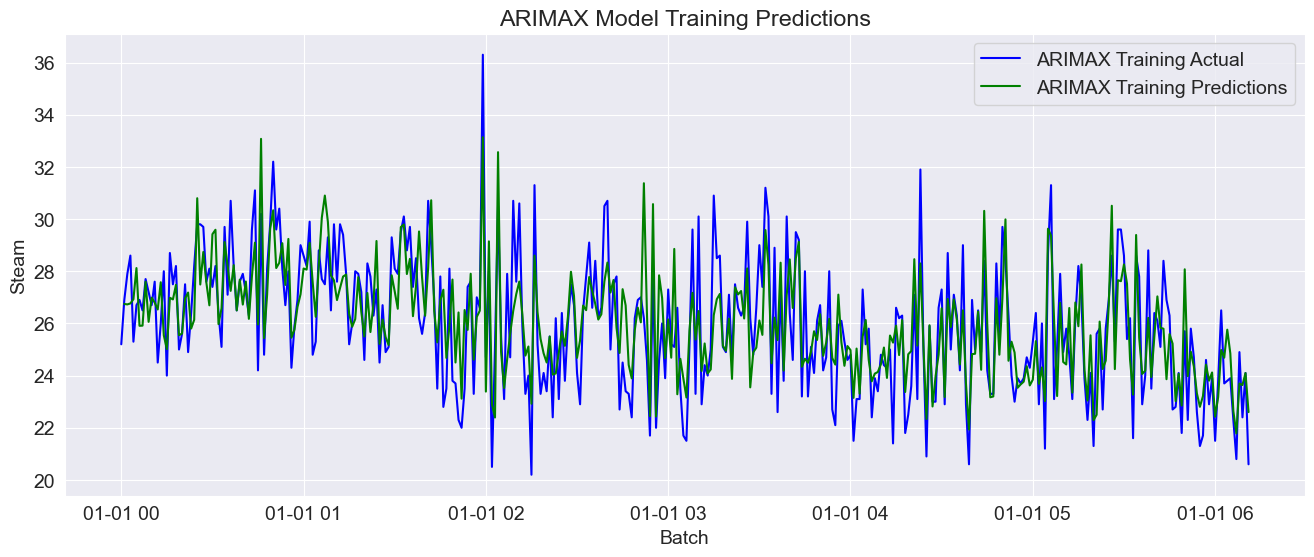

In [135]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'
exog_vars_test = data15_test[['Delta', 'Damkohler', 'Sigma']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [136]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.sqrt(mean_absolute_percentage_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

r_squared = r2_score(data15_train['CUM_Steam'], train_predictions['predicted_mean'])


print('mae', mae)
print('rmse', rmse)
print('mape', mape)
print('r2', r_squared)

mae 1.3152550600659911
rmse 1.6908913798340917
mape 0.2252498844603961
r2 0.5608219156465155


### ARIMAX test plots

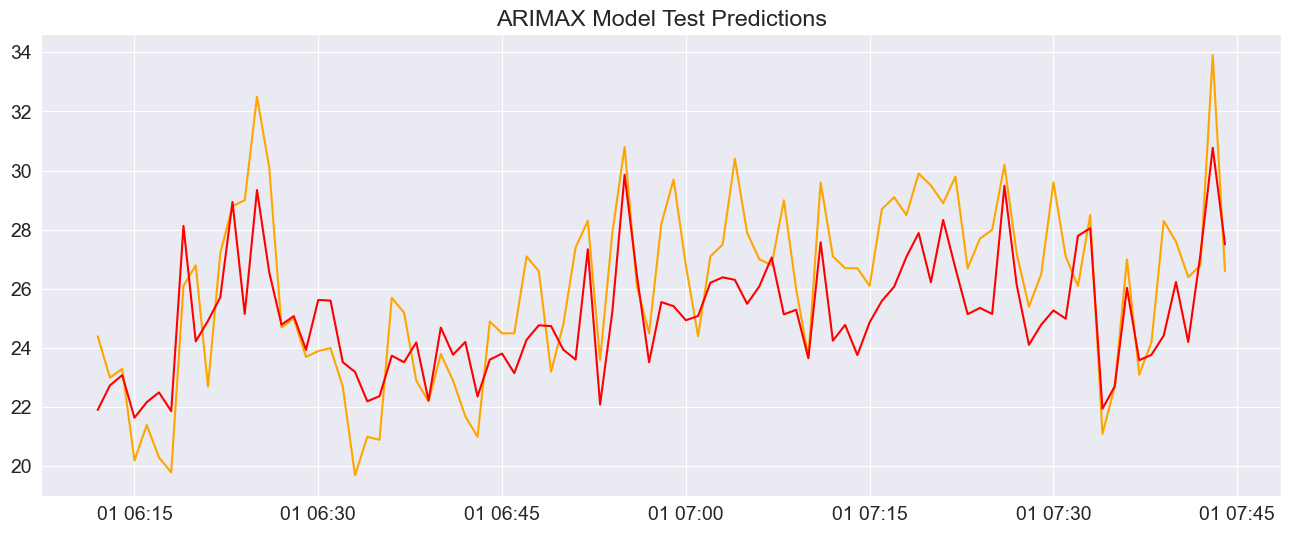

In [137]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Add labels and legend
plt.title('ARIMAX Model Test Predictions')

# Show plot
plt.show()

In [138]:
residuals = data15_train['CUM_Steam'] - train_predictions['predicted_mean']

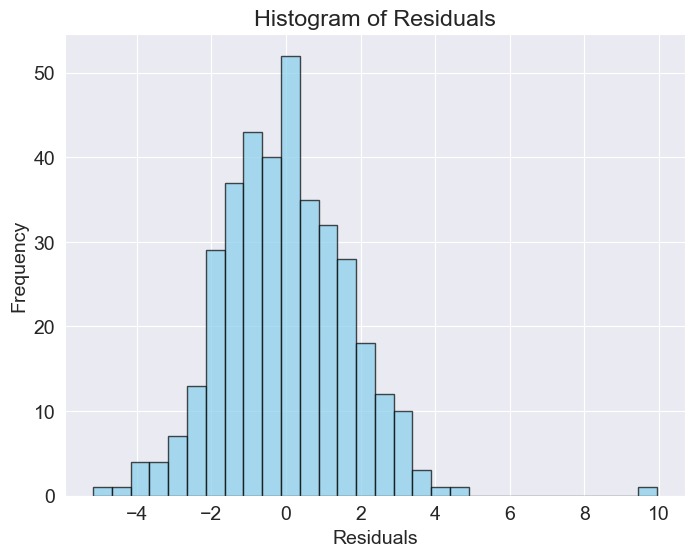

In [139]:
# Create a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Add a grid for better visualization
plt.grid(True)

# Show plot
plt.show()

### Test Performance

In [140]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.sqrt(mean_absolute_percentage_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

r_squared = r2_score(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

print('mae', mae)
print('rmse', rmse)
print('mape', mape)
print('r2', r_squared)

mae 1.690760351606361
rmse 2.0295382829599884
mape 0.25302163706373115
r2 0.5281228232313007
